# W2 Form Extraction - Fine-tune on Amazon Bedrock

Submit and monitor a fine-tuning job for Amazon Nova Lite on our W2 tax form dataset.

In this notebook we will:

- Create a model customization job on Bedrock
- Monitor the training job status
- Visualize the step-wise training loss

**Prerequisite:** Run `02_data_preparation.ipynb` first.

## Environment Setup

In [ ]:
import time
import warnings
warnings.filterwarnings("ignore")

from util import *

clients = get_aws_clients()
s3_client = clients["s3"]
bedrock   = clients["bedrock"]

In [ ]:
%store -r bucket_name
%store -r train_data_uri
%store -r role_arn

print(f"Bucket name:         {bucket_name}")
print(f"Training data URI:   {train_data_uri}")
print(f"Role ARN:            {role_arn}")

## Create Fine-tuning Job

In [ ]:
nova_lite_base_model_arn = "arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-2-lite-v1:0:256k"

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
job_name = f"nova-multimodal-ft-{timestamp}"
custom_model_name = f"nova-multimodel-{timestamp}"

hyperparameters = {
    "epochCount": "2",
    "batchSize": "1",
    "learningRate": "0.00001",
}

output_s3_uri = f"s3://{bucket_name}/output/"

In [ ]:
try:
    response = bedrock.create_model_customization_job(
        customizationType="FINE_TUNING",
        jobName=job_name,
        customModelName=custom_model_name,
        roleArn=role_arn,
        baseModelIdentifier=nova_lite_base_model_arn,
        hyperParameters=hyperparameters,
        trainingDataConfig={"s3Uri": train_data_uri},
        outputDataConfig={"s3Uri": output_s3_uri},
    )
    job_arn = response["jobArn"]
    print(f"Fine-tuning job created: {job_arn}")
except Exception as e:
    print(f"Error creating fine-tuning job: {e}")

## Monitor Job Status

This cell polls the job status every 20 minutes until the job completes or fails.

In [6]:
import time

current_status = None
while True:
    current_status = check_job_status(bedrock, job_arn)
    print(f"Job status: {current_status}")

    if current_status != "InProgress":
        break

    time.sleep(1200)

Job status: Completed


In [ ]:
if current_status == "Completed":
    model_details = bedrock.get_model_customization_job(jobIdentifier=job_arn)
    custom_model_arn = model_details["outputModelArn"]
    print(f"Fine-tuned model ARN: {custom_model_arn}")

## Visualize Training Metrics

Ensure the job status is **Completed** before running the cells below.

Metrics downloaded successfully


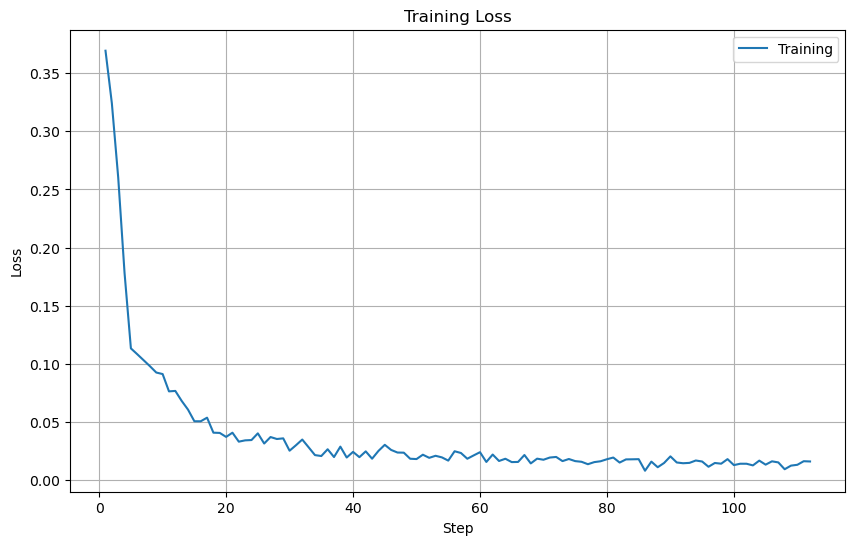

In [7]:
metrics_file = download_training_metrics(s3_client, bucket_name, job_arn)

if metrics_file:
    plot_training_metrics(metrics_file)

## Save Variables

In [ ]:
# Retrieve custom model ARN if not already set
if "custom_model_arn" not in dir():
    model_details = bedrock.get_model_customization_job(jobIdentifier=job_arn)
    custom_model_arn = model_details["outputModelArn"]

%store job_arn
%store custom_model_arn

print(f"Custom model ARN: {custom_model_arn}")
print("Variables saved for subsequent notebooks")